In [27]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from datetime import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [28]:
def get_cols(df: pd.DataFrame) -> tuple:
    numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
    categorical_columns = df.select_dtypes(exclude=np.number).columns.tolist()

    return numeric_columns, categorical_columns

zona_departamento = {
    'Norte': ['LAMBAYEQUE', 'CAJAMARCA', 'PIURA', 'TUMBES', 'LA LIBERTAD', 'AMAZONAS', 'SAN MARTIN', 'LORETO'],
    'Centro': ['JUNIN', 'ANCASH', 'HUANUCO', 'HUANCAVELICA', 'PASCO', 'AYACUCHO', 'UCAYALI'],
    'Sur': ['AREQUIPA', 'MOQUEGUA', 'TACNA', 'CUSCO', 'PUNO', 'MADRE DE DIOS', 'ICA', 'APURIMAC', 'LIMA', 'CALLAO']
}
departamento_a_region = { v: k for k, values in zona_departamento.items() for v in values}

def asignar_region(departamento):
    return departamento_a_region.get(departamento, 'DESCONOCIDO')

In [29]:
df_customers_imputed = pd.read_parquet('../data/raw/costumer_imputed_one_hot.gzip')
df_imputed = pd.read_parquet('../data/processed/customers_departamento_imputed.gzip')

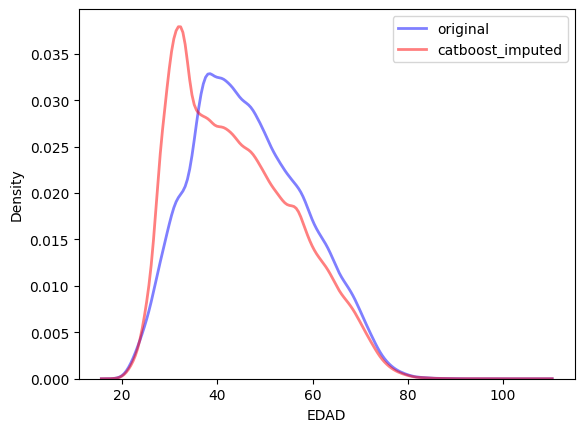

In [30]:
df_customers = (
    pd.read_csv('../data/raw/customers.csv')
    .assign(
        PER_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].astype(str)
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[:4],
        MES_BANCARIZACION = lambda row: row['PER_BANCARIZACION'].str[5:7]
    )
    .assign(
        ANIO_BANCARIZACION = lambda row: row['ANIO_BANCARIZACION'].astype(int),
        MES_BANCARIZACION = lambda row: row['MES_BANCARIZACION'].astype(int),
        # FECHA_BANCARIZACION = lambda row: pd.to_datetime()
    )
    .drop(columns=['PER_BANCARIZACION', 'DE_CIIU'])
)

sns.kdeplot(df_customers['EDAD'], label='original', linewidth=2, color='blue', alpha=0.5)
sns.kdeplot(df_customers_imputed['num__EDAD'], label='catboost_imputed', linewidth=2, color='red', alpha=0.5)
plt.legend()
plt.show()

In [31]:
df_customers.loc[lambda df : (df['MES_BANCARIZACION']) < 1 | (df['MES_BANCARIZACION'] > 12), ['MES_BANCARIZACION']] = 1
df_customers['FECHA_BANCARIZACION'] = pd.to_datetime(df_customers['ANIO_BANCARIZACION'].astype(str) + df_customers['MES_BANCARIZACION'].astype(str).str.zfill(2), format='%Y%m')
df_customers['CO_TIPO_SEXO'] = df_customers['CO_TIPO_SEXO'].astype('category')
df_customers['NO_DEPARTAMENTO'] = df_customers['NO_DEPARTAMENTO'].replace('nan', np.nan)
df_customers['NO_DEPARTAMENTO'] = df_customers['NO_DEPARTAMENTO'].astype('category')

df_customers['MESES_HASTA_ACTUAL'] = (datetime.now() - df_customers['FECHA_BANCARIZACION']) // pd.Timedelta(days=30)      # astype('<m8[M]')
df_customers = df_customers.drop(columns=['ANIO_BANCARIZACION', 'MES_BANCARIZACION', 'FECHA_BANCARIZACION'])
df_customers['EDAD'] = df_customers_imputed['num__EDAD']
df_customers['NO_DEPARTAMENTO'] = df_imputed['NO_DEPARTAMENTO']

print(df_customers.isna().sum())
display(df_customers)
print(df_customers.dtypes)

ID                        0
CO_TIPO_SEXO              0
EDAD                      0
NO_DEPARTAMENTO           0
NO_PROVINCIA          75744
MESES_HASTA_ACTUAL        0
dtype: int64


,ID,CO_TIPO_SEXO,EDAD,NO_DEPARTAMENTO,NO_PROVINCIA,MESES_HASTA_ACTUAL
0,8bd775237f2f4c7cae87c255e9e71d62,1,48.000000,CAJAMARCA,CONTUMAZA,126
1,2409b242893e4ea4b7e6af1292030666,3,28.200000,LAMBAYEQUE,NaN,75
2,65edb7eb9d144b2184ef76ec2c35cdf8,1,38.000000,MOQUEGUA,NaN,192
3,2fef711096234036807b01a5a697a81c,1,61.000000,TACNA,TACNA,217
4,796443da390d409ba3e7b775fde576cd,3,29.000000,LAMBAYEQUE,CHICLAYO,115
...,...,...,...,...,...,...
151967,54a73b9c515f46d19c0182e3f44f44fe,3,25.000000,LORETO,NaN,28
151968,1df55d6b6af544b58312d68241a10e4f,3,32.000000,LAMBAYEQUE,CHICLAYO,63
151969,5dd4a95d877d4474a277173c6fe4d227,1,62.000000,AYACUCHO,NaN,217
151970,cbad53becdb042cfb98a992566ec0e94,2,51.000000,LORETO,NaN,131


ID                      object
CO_TIPO_SEXO          category
EDAD                   float64
NO_DEPARTAMENTO         object
NO_PROVINCIA            object
MESES_HASTA_ACTUAL       int64
dtype: object


In [32]:
df_customers

,ID,CO_TIPO_SEXO,EDAD,NO_DEPARTAMENTO,NO_PROVINCIA,MESES_HASTA_ACTUAL
0,8bd775237f2f4c7cae87c255e9e71d62,1,48.000000,CAJAMARCA,CONTUMAZA,126
1,2409b242893e4ea4b7e6af1292030666,3,28.200000,LAMBAYEQUE,NaN,75
2,65edb7eb9d144b2184ef76ec2c35cdf8,1,38.000000,MOQUEGUA,NaN,192
3,2fef711096234036807b01a5a697a81c,1,61.000000,TACNA,TACNA,217
4,796443da390d409ba3e7b775fde576cd,3,29.000000,LAMBAYEQUE,CHICLAYO,115
...,...,...,...,...,...,...
151967,54a73b9c515f46d19c0182e3f44f44fe,3,25.000000,LORETO,NaN,28
151968,1df55d6b6af544b58312d68241a10e4f,3,32.000000,LAMBAYEQUE,CHICLAYO,63
151969,5dd4a95d877d4474a277173c6fe4d227,1,62.000000,AYACUCHO,NaN,217
151970,cbad53becdb042cfb98a992566ec0e94,2,51.000000,LORETO,NaN,131


In [33]:
df_customers[
    ['NO_DEPARTAMENTO', 'NO_PROVINCIA']
].groupby(['NO_DEPARTAMENTO']).agg(['nunique'])

,NO_PROVINCIA
,nunique
NO_DEPARTAMENTO,
AMAZONAS,7
ANCASH,20
APURIMAC,7
AREQUIPA,8
AYACUCHO,11
CAJAMARCA,13
CALLAO,1
CUSCO,7


In [35]:
df_customers.isna().sum()

ID                    0
CO_TIPO_SEXO          0
EDAD                  0
NO_DEPARTAMENTO       0
NO_PROVINCIA          0
MESES_HASTA_ACTUAL    0
dtype: int64